In [36]:
import os
import copy
import math
import typing
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm.layers as timmm


NoneFloat = typing.Union[None, float]
figure_path = '/Users/davidfarache/Documents/ML-ToolBox/VisionTransformers/TransformerFiles'

# Image Tokenization

Mountain at Dusk is H = 60 and W = 100 pixels.




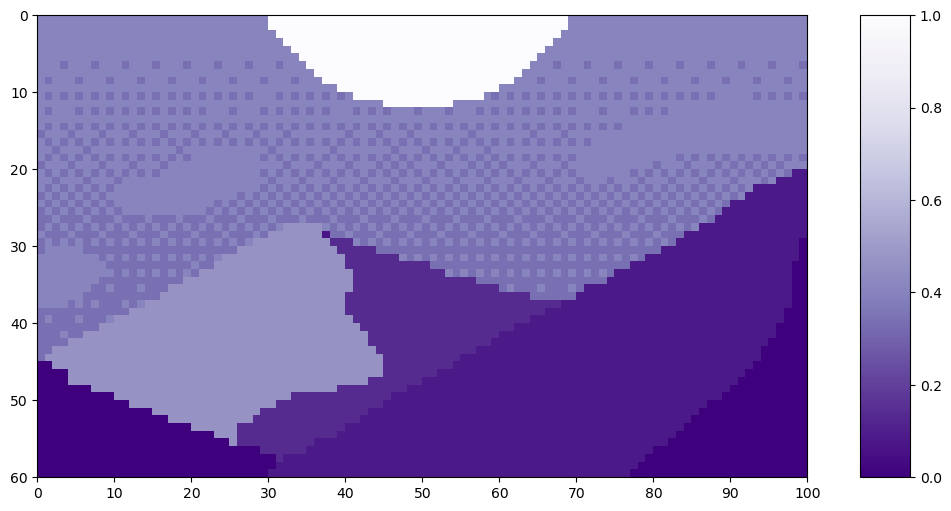

In [37]:
# ViT converts an image to tokens such that each token represents a local area 
mountains = np.load(os.path.join(figure_path, 'mountains.npy'))

H = mountains.shape[0]
W = mountains.shape[1]
print('Mountain at Dusk is H =', H, 'and W =', W, 'pixels.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains.png'), bbox_inches='tight')

There will be 15 patches, each 20 by 20.




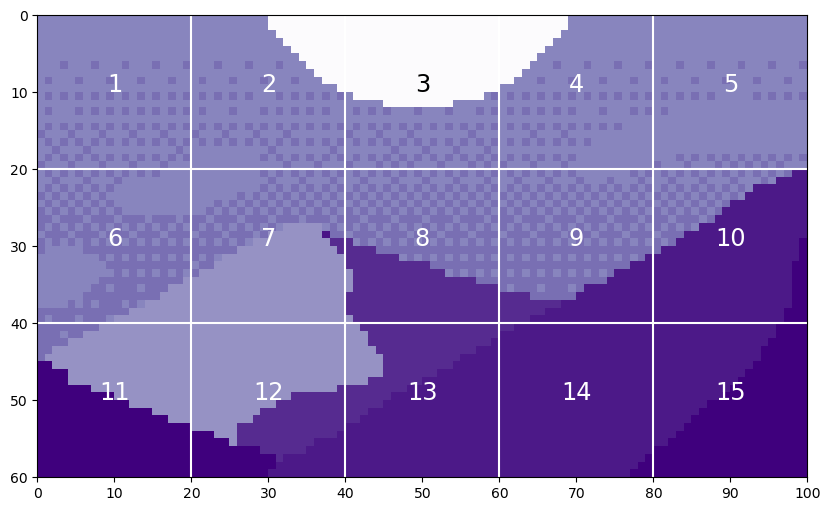

In [38]:
P = 20
# They describe reshaping an image of height H, width W, and channels C into N tokens with patch size 
N = int((H*W)/(P**2)) # Get number token given patch
print('There will be', N, 'patches, each', P, 'by', str(P)+'.')
print('\n')

# Display segmentation
fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.clim([0,1])
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text = np.tile(np.arange(9.5, W, P), 3)
y_text = np.repeat(np.arange(9.5, H, P), 5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');
#plt.savefig(os.path.join(figure_path, 'mountain_patches.png'), bbox_inches='tight')

Each patch will make a token of length 400.




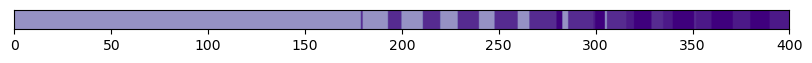

In [39]:
# lattening these patches, we see the resulting tokens. (Patch 6 below)
print('Each patch will make a token of length', str(P**2)+'.')
print('\n')

patch12 = mountains[40:60, 20:40]
token12 = patch12.reshape(1, P**2)

fig = plt.figure(figsize=(10,1))
plt.imshow(token12, aspect=10, cmap='Purples_r')
plt.clim([0,1])
plt.xticks(np.arange(-0.5, 401, 50), labels=np.arange(0, 401, 50))
plt.yticks([]);
#plt.savefig(os.path.join(figure_path, 'mountain_token12.png'), bbox_inches='tight')

In [40]:
class Patch_Tokenization(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 1, 60, 100),
                patch_size: int=50,
                token_len: int=768):

        """ Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()
        
        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H / self.patch_size) * (W / self.patch_size)

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        x = self.split(x).transpose(1,0)
        x = self.project(x)
        return x

In [46]:
x = torch.from_numpy(mountains).unsqueeze(0).unsqueeze(0).to(torch.float32)
token_len = 768
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

# Define the Module
patch_tokens = Patch_Tokenization(img_size=(x.shape[1], x.shape[2], x.shape[3]),
                                    patch_size = P,
                                    token_len = token_len)

x = patch_tokens.split(x).transpose(2,1)
print('After patch tokenization, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

x = patch_tokens.project(x)
print('After projection, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Input dimensions are
	batchsize: 1 
	number of input channels: 1 
	image size: (60, 100)
After patch tokenization, dimensions are
	batchsize: 1 
	number of tokens: 15 
	token length: 400
After projection, dimensions are
	batchsize: 1 
	number of tokens: 15 
	token length: 768


# Token Processing

In [48]:
# Define an Input
num_tokens = 175
token_len = 768
batch = 13
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# Append a Prediction Token
pred_token = torch.zeros(1, 1, token_len).expand(batch, -1, -1)
print('Prediction Token dimensions are\n\tbatchsize:', pred_token.shape[0], '\n\tnumber of tokens:', pred_token.shape[1], '\n\ttoken length:', pred_token.shape[2])

x = torch.cat((pred_token, x), dim=1)
print('Dimensions with Prediction Token are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Input dimensions are
	batchsize: 13 
	number of tokens: 175 
	token length: 768
Prediction Token dimensions are
	batchsize: 13 
	number of tokens: 1 
	token length: 768
Dimensions with Prediction Token are
	batchsize: 13 
	number of tokens: 176 
	token length: 768


In [49]:
# Add position embedding for token
def get_sinusoid_encoding(num_tokens, token_len):
    """ Make Sinusoid Encoding Table

        Args:
            num_tokens (int): number of tokens
            token_len (int): length of a token
            
        Returns:
            (torch.FloatTensor) sinusoidal position encoding table
    """

    def get_position_angle_vec(i):
        return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]

    sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 

    return torch.FloatTensor(sinusoid_table).unsqueeze(0)

PE = get_sinusoid_encoding(num_tokens+1, token_len)
print('Position embedding dimensions are\n\tnumber of tokens:', PE.shape[1], '\n\ttoken length:', PE.shape[2])

x = x + PE
print('Dimensions with Position Embedding are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Position embedding dimensions are
	number of tokens: 176 
	token length: 768
Dimensions with Position Embedding are
	batchsize: 13 
	number of tokens: 176 
	token length: 768


# Encoding Block

In [ ]:
class Attention(nn.Module):
    def __init__(self, 
                dim: int,
                chan: int,
                num_heads: int=1,
                qkv_bias: bool=False,
                qk_scale: NoneFloat=None):

        """ Attention Module

            Args:
                dim (int): input size of a single token
                chan (int): resulting size of a single token (channels)
                num_heads(int): number of attention heads in MSA (only works if =1)
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
        """

        super().__init__()

        ## Define Constants
        self.num_heads = num_heads
        self.chan = chan
        self.head_dim = self.chan // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5

        ## Define Layers
        self.qkv = nn.Linear(dim, chan * 3, bias=qkv_bias)
        ## Each token gets projected from starting token_len to channel length 3 times (once for each Q,K,V)
        self.proj = nn.Linear(chan, chan)

    def forward(self, x):
        if self.chan % self.num_heads != 0:
            raise ValueError('"Chan" must be evenly divisible by "num_heads".')
            
        B, N, C = x.shape
        ## Dimensions: (batch, num_tokens, token_len)

        ## Calcuate QKVs
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        ## Dimensions: (qkv, batch, heads, num_tokens, token_len = chan/num_heads = head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ## Calculate Attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        ## Dimensions: (batch, heads, num_tokens, num_tokens)

        ## Attention Layer
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.chan)
        ## Dimensions: (batch, heads, num_tokens, token_len = chan)

        ## Projection Layers
        x = self.proj(x)

        ## Skip Connection Layer
        v = v.transpose(1, 2).reshape(B, N, self.chan)
        x = v + x     
        ## Because the original x has different size with current x, use v to do skip connection

        return x

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self,
    			in_chan: int,
    			hidden_chan: NoneFloat=None,
    			out_chan: NoneFloat=None,
    			act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [ ]:
class Encoding(nn.Module):

    def __init__(self,
       dim: int,
       num_heads: int=1,
       hidden_chan_mul: float=4.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU, 
       norm_layer=nn.LayerNorm):
        
        """ Encoding Block

            Args:
                dim (int): size of a single token
                num_heads(int): number of attention heads in MSA
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim=dim,
                            chan=dim,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        self.neuralnet = NeuralNet(in_chan=dim,
                                hidden_chan=int(dim*hidden_chan_mul),
                                out_chan=dim,
                                act_layer=act_layer)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

In [ ]:
# Define an Input
num_tokens = 176
token_len = 768
batch = 13
heads = 4
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# Define the Module
E = Encoding(dim=token_len, num_heads=heads, hidden_chan_mul=1.5, qkv_bias=False, qk_scale=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
E.eval();

In [ ]:
y = E.norm1(x)
print('After norm, dimensions are\n\tbatchsize:', y.shape[0], '\n\tnumber of tokens:', y.shape[1], '\n\ttoken size:', y.shape[2])
y = E.attn(y)
print('After attention, dimensions are\n\tbatchsize:', y.shape[0], '\n\tnumber of tokens:', y.shape[1], '\n\ttoken size:', y.shape[2])
y = y + x
print('After split connection, dimensions are\n\tbatchsize:', y.shape[0], '\n\tnumber of tokens:', y.shape[1], '\n\ttoken size:', y.shape[2])

In [ ]:
z = E.norm2(y)
print('After norm, dimensions are\n\tbatchsize:', z.shape[0], '\n\tnumber of tokens:', z.shape[1], '\n\ttoken size:', z.shape[2])
z = E.neuralnet(z)
print('After neural net, dimensions are\n\tbatchsize:', z.shape[0], '\n\tnumber of tokens:', z.shape[1], '\n\ttoken size:', z.shape[2])
z = z + y
print('After split connection, dimensions are\n\tbatchsize:', z.shape[0], '\n\tnumber of tokens:', z.shape[1], '\n\ttoken size:', z.shape[2])

# Neural Network

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self,
       in_chan: int,
       hidden_chan: NoneFloat=None,
       out_chan: NoneFloat=None,
       act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [ ]:
# Define an Input
num_tokens = 176
token_len = 768
batch = 1
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

norm = nn.LayerNorm(token_len)
x = norm(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

pred_token = x[:, 0]
print('Length of prediction token:', pred_token.shape[-1])

In [ ]:
head = nn.Linear(token_len, 1)
pred = head(pred_token)
print('Length of prediction:', (pred.shape[0], pred.shape[1]))
print('Prediction:', float(pred))

# Complete Code

In [50]:
class ViT_Backbone(nn.Module):
    def __init__(self,
                preds: int=1,
                token_len: int=768,
                num_heads: int=1,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Backbone
            Args:
                preds (int): number of predictions to output
                token_len (int): length of a token
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                 if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Token Processing Components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        self.pos_embed = nn.Parameter(data=get_sinusoid_encoding(num_tokens=self.num_tokens+1, token_len=self.token_len), requires_grad=False)
        
        ## Defining Encoding blocks
        self.blocks = nn.ModuleList([Encoding(dim = self.token_len, 
                                               num_heads = self.num_heads,
                                               hidden_chan_mul = self.Encoding_hidden_chan_mul,
                                               qkv_bias = qkv_bias,
                                               qk_scale = qk_scale,
                                               act_layer = act_layer,
                                               norm_layer = norm_layer)
             for i in range(self.depth)])

        ## Defining Prediction Processing
        self.norm = norm_layer(self.token_len)
        self.head = nn.Linear(self.token_len, preds)

        ## Make the class token sampled from a truncated normal distrobution 
        timm.layers.trunc_normal_(self.cls_token, std=.02)

    def forward(self, x):
        ## Assumes x is already tokenized

        ## Get Batch Size
        B = x.shape[0]
        ## Concatenate Class Token
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1)
        ## Add Positional Embedding
        x = x + self.pos_embed
        ## Run Through Encoding Blocks
        for blk in self.blocks:
            x = blk(x)
        ## Take Norm
        x = self.norm(x)
        ## Make Prediction on Class Token
        x = self.head(x[:, 0])
        return x

In [51]:
class ViT_Model(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 400, 100),
                patch_size: int=50,
                token_len: int=768,
                preds: int=1,
                num_heads: int=1,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Model
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
                preds (int): number of predictions to output
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """
        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Patch Embedding Module
        self.patch_tokens = Patch_Tokenization(img_size,
        patch_size,
        token_len)

        ## Defining ViT Backbone
        self.backbone = ViT_Backbone(preds,
                                    self.token_len,
                                    self.num_heads,
                                    self.Encoding_hidden_chan_mul,
                                    self.depth,
                                    qkv_bias,
                                    qk_scale,
                                    act_layer,
                                    norm_layer)
        ## Initialize the Weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """ Initialize the weights of the linear layers & the layernorms
        """
        ## For Linear Layers
        if isinstance(m, nn.Linear):
            ## Weights are initialized from a truncated normal distrobution
            timm.layers.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                ## If bias is present, bias is initialized at zero
                nn.init.constant_(m.bias, 0)
        ## For Layernorm Layers
        elif isinstance(m, nn.LayerNorm):
            ## Weights are initialized at one
            nn.init.constant_(m.weight, 1.0)
            ## Bias is initialized at zero
            nn.init.constant_(m.bias, 0)

    @torch.jit.ignore ##Tell pytorch to not compile as TorchScript
    def no_weight_decay(self):
        """ Used in Optimizer to ignore weight decay in the class token
        """
        return {'cls_token'}

    def forward(self, x):
        x = self.patch_tokens(x)
        x = self.backbone(x)
        return x